In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

import akita_utils 
import pysam
import h5py
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-06-22 13:04:55.270825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1310720, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1310720, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1310720, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1310720, 4)   0           stochastic_shift[0][0]           
____________________________________________________________________________________________

(512, 130305, (130305,))

# Fetching chromosome data to explore background creation

In [3]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced')
bins = bioframe.binnify(chromsizes, 1310720)
df = bioframe.frac_gc(bins, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)
df

,chrom,start,end,GC
0,chr1,0,1310720,NaN
1,chr1,1310720,2621440,NaN
2,chr1,2621440,3932160,0.386460
3,chr1,3932160,5242880,0.401122
4,chr1,5242880,6553600,0.393862
...,...,...,...,...
2085,chrY,86507520,87818240,0.392786
2086,chrY,87818240,89128960,0.390694
2087,chrY,89128960,90439680,0.384166
2088,chrY,90439680,91744698,0.417601


In [4]:
# plt.hist( df['GC'].values, 100);
np.percentile(df['GC'].dropna().values, np.linspace(1,99,50))

array([0.36257709, 0.36587454, 0.36817734, 0.37065207, 0.37299786,
       0.37570795, 0.37762457, 0.37970245, 0.38174762, 0.3842182 ,
       0.38629681, 0.38790781, 0.38917107, 0.3905381 , 0.39205158,
       0.3936232 , 0.3960943 , 0.39810775, 0.40056351, 0.40236493,
       0.40381584, 0.40533798, 0.40708984, 0.40936343, 0.41157089,
       0.41348972, 0.41546698, 0.41760017, 0.42007883, 0.42148009,
       0.42376548, 0.4263613 , 0.42851746, 0.42988721, 0.43299001,
       0.43606558, 0.4383895 , 0.44031067, 0.44245801, 0.44505133,
       0.447931  , 0.45059813, 0.45486053, 0.45826593, 0.46257977,
       0.46890153, 0.47304071, 0.47886063, 0.48705676, 0.50131308])

# Generating a sample for down stream analysis

In [5]:
sample_set = []
error = 0.01

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,50)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            sample_set += [i]
            break

# print(set(sample_set), len(set(sample_set)))

sample_set = list(set(sample_set))
sample_set = sample_set[2:4]

print(sample_set)

[6, 7]


In [6]:
shuffle_set = [2,4,8]
scores = {}

for gc in sample_set:
    for k in [2,4,8]:

        scores[gc,k] = akita_utils.custom_calculate_scores(seqnn_model=seqnn_model, 
                                                            genome_fasta=genome_fasta, 
                                                            seq_length=seq_length, 
                                                            dataframe=df, 
                                                            sample_set=[sample_set[sample_set.index(gc)]], 
                                                            devisor = 2,  # iterations wil be tracked in multiples of this number
                                                            max_iters = 3, 
                                                            batch_size = 6, 
                                                            shuffle_k = k, 
                                                            ctcf_thresh = 8, 
                                                            scores_thresh = 5500, 
                                                            scores_pixelwise_thresh = .04)

6
ind 6 , iter  0 , for chr1 7864320 9175040


2022-06-22 13:06:03.321547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-22 13:06:03.322297: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2593500000 Hz


ind 6 , iter  1 , for chr1 7864320 9175040
ind 6 , iter  2 , for chr1 7864320 9175040
max iters exceeded
6
ind 6 , iter  0 , for chr1 7864320 9175040
ind 6 , iter  1 , for chr1 7864320 9175040
ind 6 , iter  2 , for chr1 7864320 9175040
max iters exceeded
6
ind 6 , iter  0 , for chr1 7864320 9175040
ind 6 , iter  1 , for chr1 7864320 9175040
ind 6 , iter  2 , for chr1 7864320 9175040
max iters exceeded
7
ind 7 , iter  0 , for chr1 9175040 10485760
ind 7 , iter  1 , for chr1 9175040 10485760


/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 7 , iter  2 , for chr1 9175040 10485760
max iters exceeded
7
ind 7 , iter  0 , for chr1 9175040 10485760
ind 7 , iter  1 , for chr1 9175040 10485760
ind 7 , iter  2 , for chr1 9175040 10485760
max iters exceeded
7
ind 7 , iter  0 , for chr1 9175040 10485760
ind 7 , iter  1 , for chr1 9175040 10485760
ind 7 , iter  2 , for chr1 9175040 10485760
max iters exceeded


{(6, 2): array([35200., 37312., 37312., 37088., 37536., 40448.], dtype=float16), (6, 4): array([15184., 12056., 11688.,  8208., 14208., 10984.], dtype=float16), (6, 8): array([6076., 7476., 7128., 4944., 6228., 4812.], dtype=float16), (7, 2): array([51968., 52576., 49632., 47520., 57472., 50016.], dtype=float16), (7, 4): array([14856., 13120., 12504., 17440., 10824., 16296.], dtype=float16), (7, 8): array([5900., 6540., 5768., 6184., 7956., 6712.], dtype=float16)}


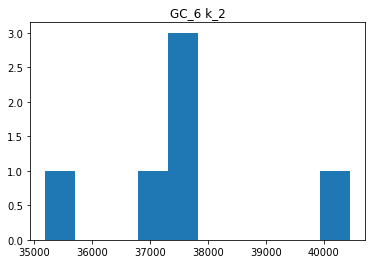

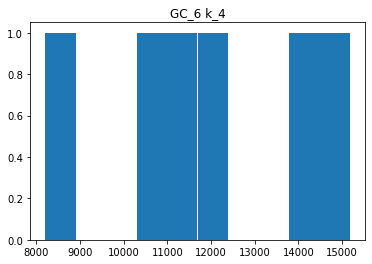

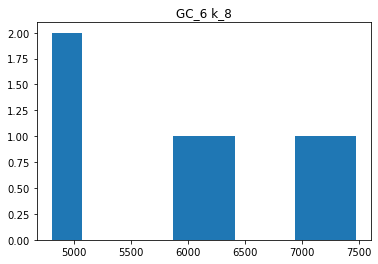

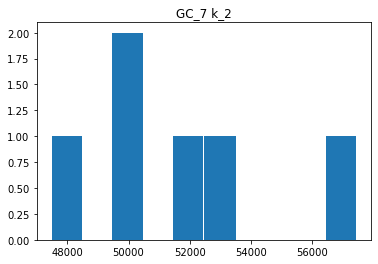

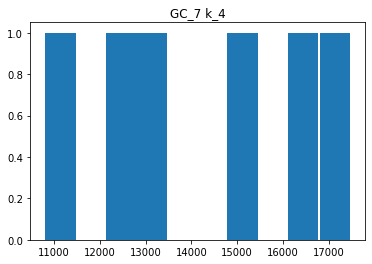

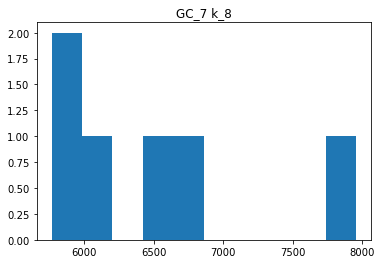

In [7]:
print(scores) 
for gc in sample_set:
    for k in shuffle_set:
        plt.hist(scores[gc,k])
        plt.title(f'GC_{gc} k_{k}')
        plt.show()
        plt.close()